# Calibration Geant4 tutorial expample B4a

In this notebook represented code solution for recovering real energy $ E_{real} $ of colliding particles ($ e^- $) in the detector using calibration prosess with known energy of $ e^- $ first and then recovering unknown energies through energy response $ E_{gap} $ of detection gap, where detector is simulated using tutorial expample B4a from standart Geant4 libraries. 

## Import libraries etc

In [1]:
import ROOT
from IPython.display import Image, display

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spopt
from scipy.stats import norm
import matplotlib.mlab as mlab
import pandas as pd
import glob

from IPython.display import display, Math, Latex
def print_math(string):
    display(Math(string))

path_to_data = '/Users/kirillivanov/Documents/Docker/geant/Geant4-10.5.1/examples/basic/B4/B4a-build2/'

Welcome to JupyROOT 6.18/00


## Calibration part

Create observable energies vars. __Energy__ is list of known energies we collide $ e^- $ with for calibration

In [3]:
Egap = ROOT.RooRealVar('Egap', 'E_{gap}, [MeV]', 0, 620)
Ereal = ROOT.RooRealVar('Ereal', 'E_{real}, [MeV]', 0, 12000)
energy = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

varset_g = ROOT.RooArgSet(Egap)

#### Importing 11 dataset with $ E_{gap} $ from generated ROOT files and define approximate mean and sigma for have them as starting points of fit

We have generated 11 ROOT files of 1000 collisions of $ e^- $ in each of them, with energy from the list above 

In [4]:
ds_list = []
mean0_list = []
sigma0_list = []

for i in range(0, 11):
    filename = f'{i}Gev'
    file = ROOT.TFile(path_to_data + filename + '.root')
    ds = ROOT.RooDataSet(f'data{i}', '', file.Get('B4'), varset_g)
    ds_list.append(ds)
    mean0_list.append(ds.mean(Egap))
    sigma0_list.append(ds.sigma(Egap))
    print(f'{i}-ds: mean0 = {round(mean0_list[i], 2)}, sigma0 = {round(sigma0_list[i], 2)}')

0-ds: mean0 = 24.7, sigma0 = 7.14
1-ds: mean0 = 50.1, sigma0 = 10.38
2-ds: mean0 = 100.31, sigma0 = 14.4
3-ds: mean0 = 151.0, sigma0 = 18.05
4-ds: mean0 = 201.22, sigma0 = 20.16
5-ds: mean0 = 250.79, sigma0 = 23.33
6-ds: mean0 = 300.49, sigma0 = 25.01
7-ds: mean0 = 351.09, sigma0 = 27.38
8-ds: mean0 = 400.7, sigma0 = 29.1
9-ds: mean0 = 449.51, sigma0 = 31.33
10-ds: mean0 = 499.22, sigma0 = 33.02


#### Fit all 10 datasets

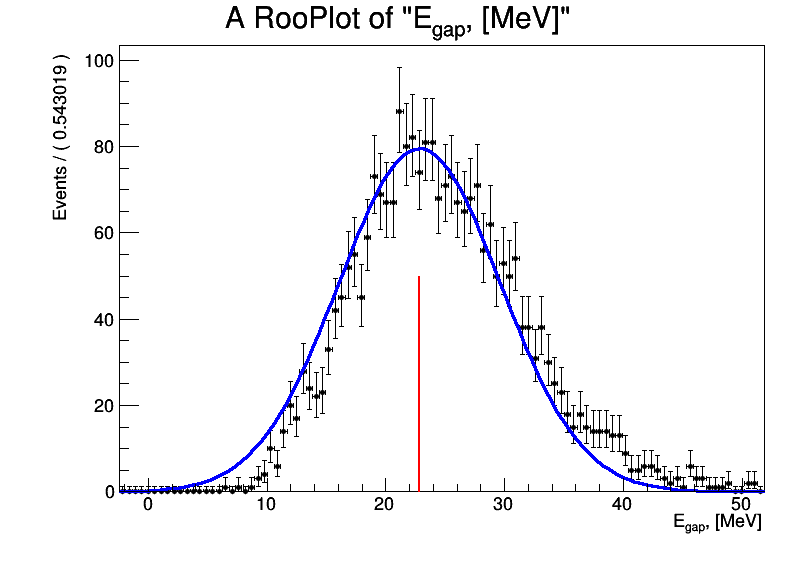

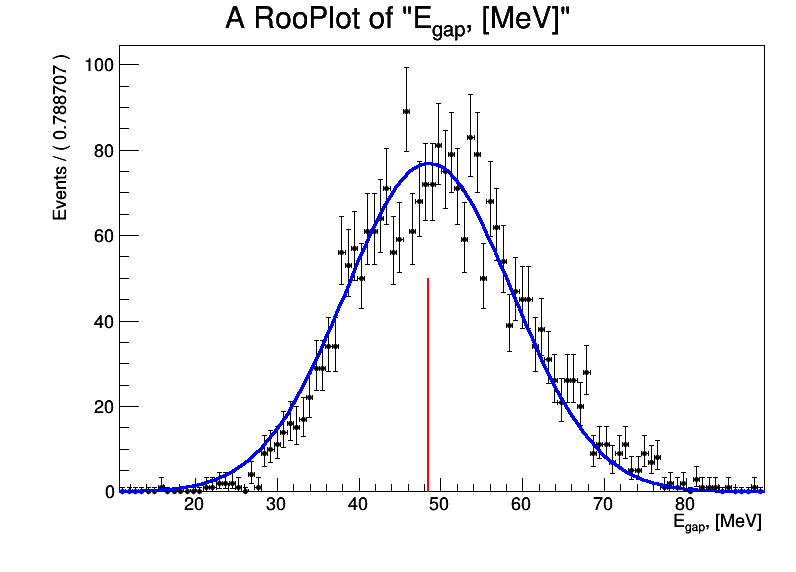

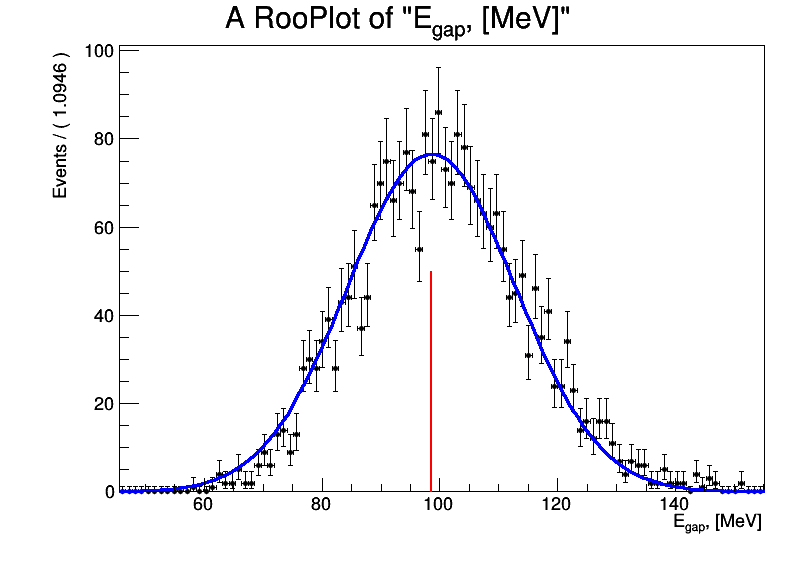

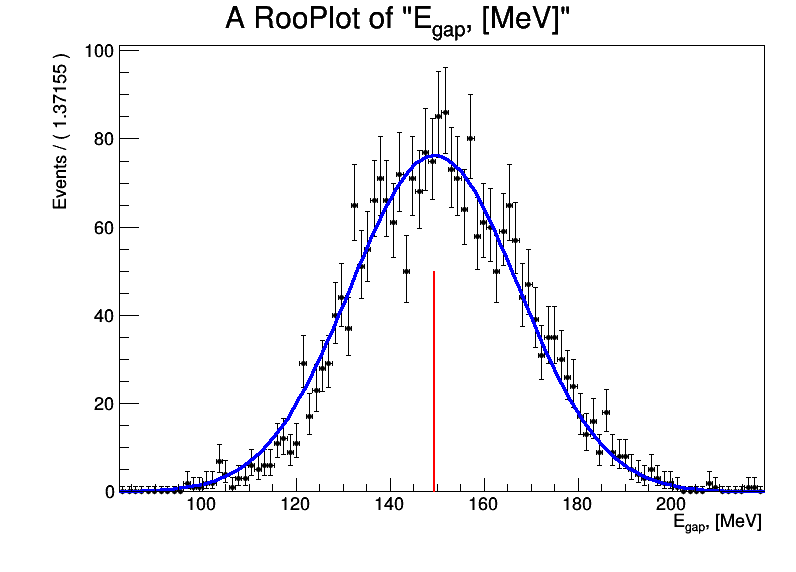

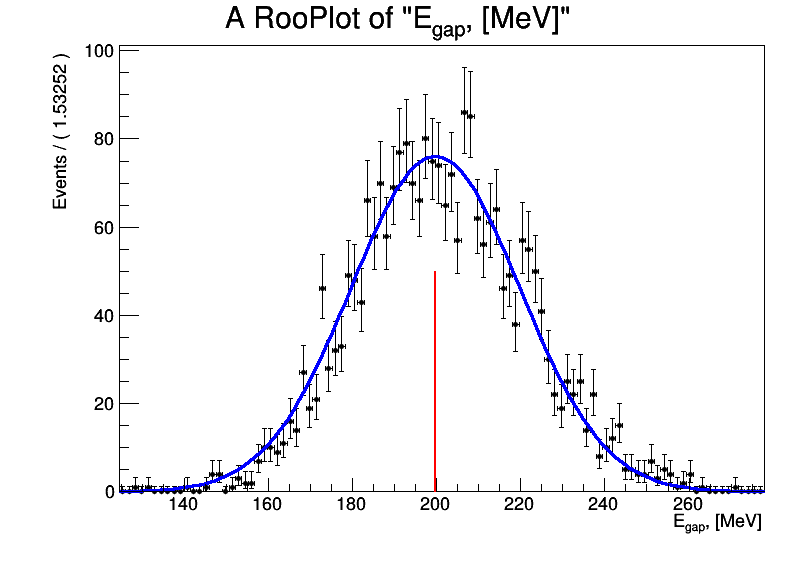

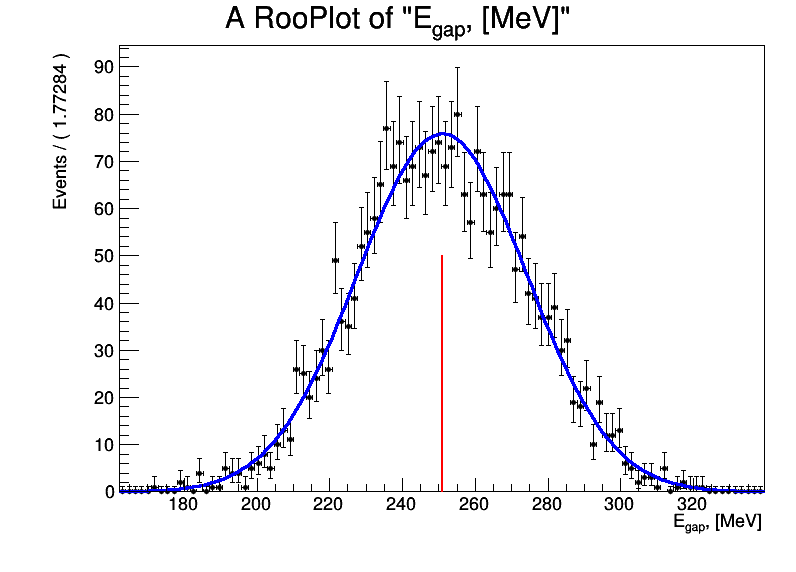

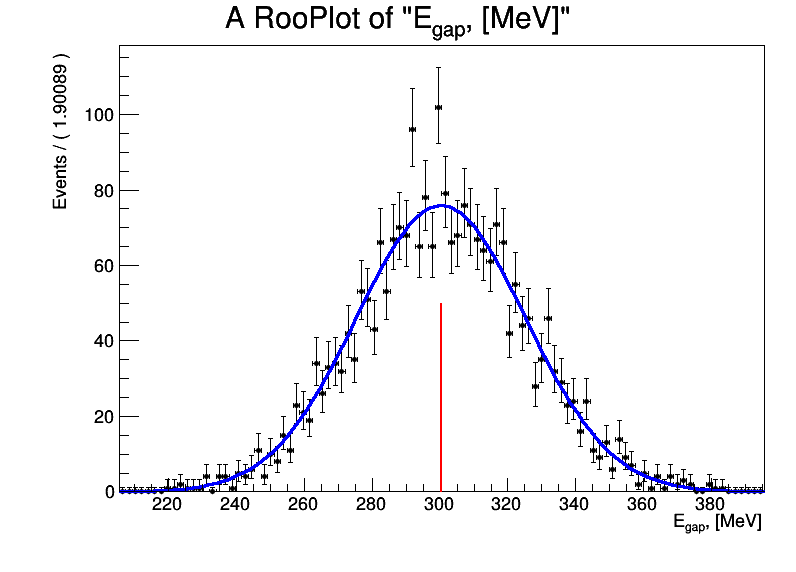

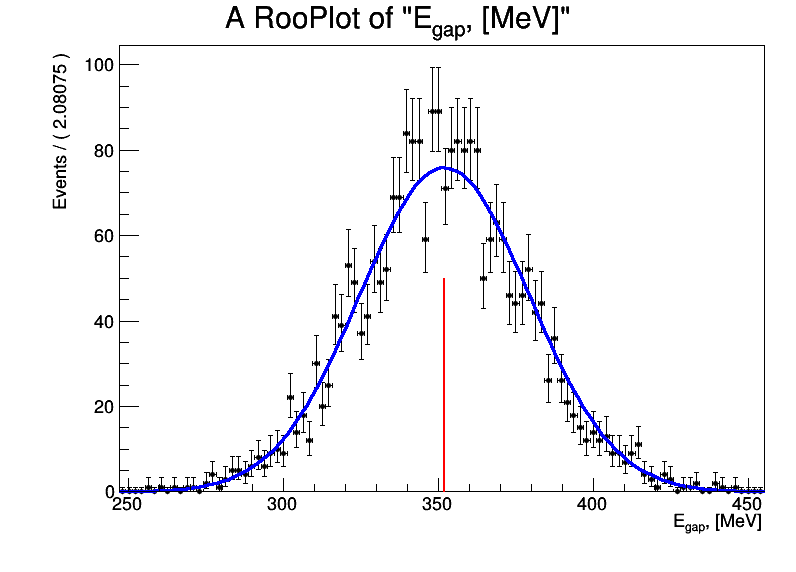

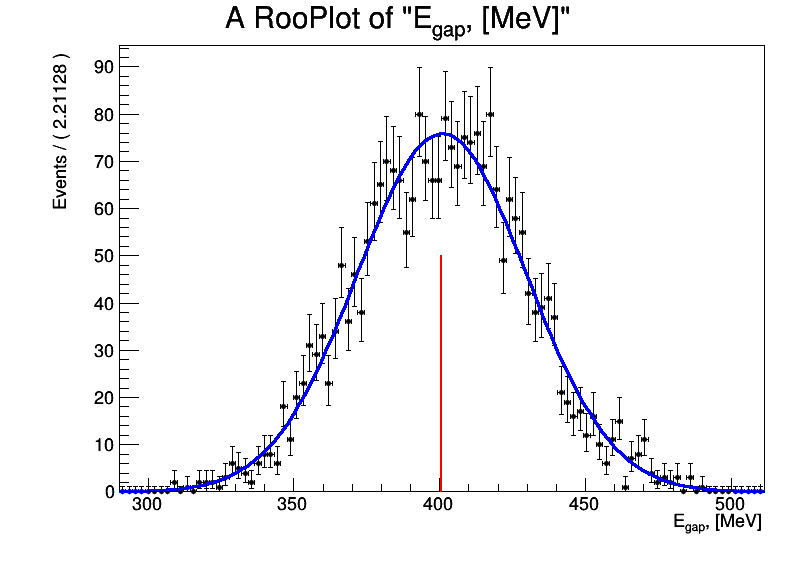

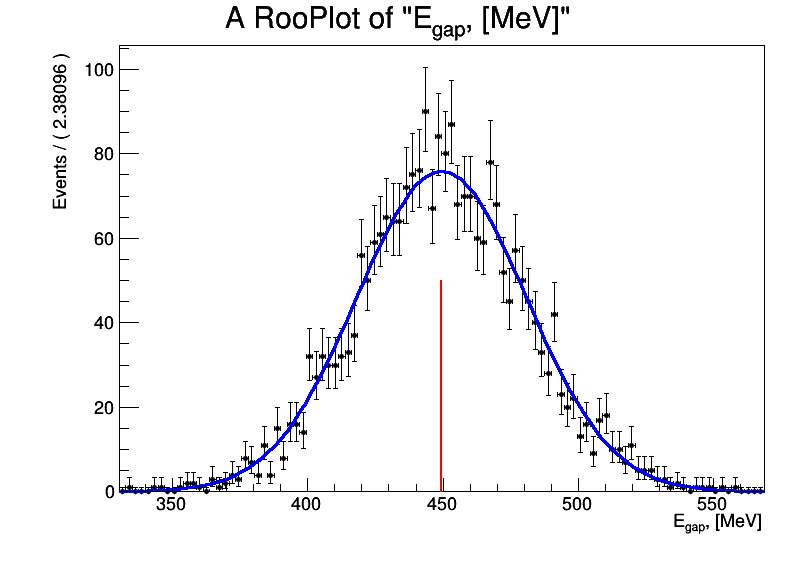

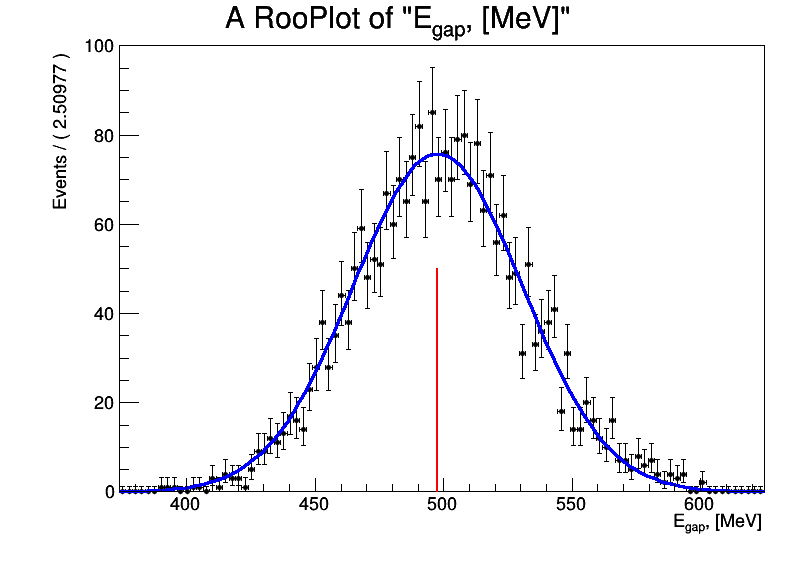

0-ds: mean = 22.84 +- 0.22
1-ds: mean = 48.53 +- 0.32
2-ds: mean = 98.58 +- 0.45
3-ds: mean = 149.49 +- 0.55
4-ds: mean = 199.73 +- 0.63
5-ds: mean = 250.89 +- 0.74
6-ds: mean = 300.27 +- 0.78
7-ds: mean = 352.02 +- 0.79
8-ds: mean = 400.77 +- 0.9
9-ds: mean = 449.48 +- 0.96
10-ds: mean = 497.69 +- 1.06
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 7 remote server process.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: deactivating const optimization

  RooFitResult: minimized FCN value: 8406.8, estimated distance to minimum: 1.71296e-06
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
           mean_ecalib    2.2838e+01 +/-  2.21e-01
          sigma_ecalib    6.8147e+00 +/-  1.00e-01
                tail_c   -1.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cB
Info in <TCanvas::Print>: png file images/png/calib_fit0.png has been created
Info in <TCanvas::Print>: pdf file images/pdf/calib_fit0.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cB
Info in <TCanvas::Print>: png file images/png/calib_fit1.png has been created
Info in <TCanvas::Print>: pdf file images/pdf/calib_fit1.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cB
Info in <TCanvas::Print>: png file images/png/calib_fit2.png has been created
Info in <TCanvas::Print>: pdf file images/pdf/calib_fit2.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cB
Info in <TCanvas::Print>: png file images/png/calib_fit3.png has been created
Info in <TCanvas::Print>: pdf file images/pdf/calib_fit3.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cB
Info in <TCanvas::Print>: 

In [6]:
mean_list = []
mean_er_list = []
gaus_calib_list = []

for i in range(0, 11):
    m = mean0_list[i]
    s = sigma0_list[i]
    mean_ecalib  = ROOT.RooRealVar ('mean_ecalib' , 'mean ', m, 0.2 * m  , 2 * m)
    sigma_ecalib = ROOT.RooRealVar ('sigma_ecalib', 'sigma', 3 * s, 0.2 * s , 10 * s)
    tail_c       = ROOT.RooRealVar ('tail_c'      , 'tail' , 0.00001, -1       , 1)

    pdf_nov_c    = ROOT.RooNovosibirsk('pdf_nov_c', 'nov'  , Egap, mean_ecalib, sigma_ecalib, tail_c)

    pdf_ecalib   = ROOT.RooGaussian('pdfEcalib'   , 'gaus', Egap, mean_ecalib, sigma_ecalib)
    pdf_landau   = ROOT.RooLandau  ('pdfEcalib_l' , 'landau', Egap, mean_ecalib, sigma_ecalib)
    
#     if i < 3:
#         fit_r = pdf_landau.fitTo(ds_list[i], ROOT.RooFit.NumCPU(7), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Save())
#         fit_r.Print()
#     else:
    fit_r = pdf_nov_c.fitTo(ds_list[i], ROOT.RooFit.NumCPU(7), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Save())
    fit_r.Print()
    
    gaus_calib_list.append(pdf_ecalib)
    mean_list.append(mean_ecalib.getVal())
    mean_er_list.append(mean_ecalib.getError())
    
    if i == 0:
        fr_min = m - 3.8 * s
        fr_max = m + 3.8 * s
    else:
        fr_min = m - 3.8 * s
        fr_max = m + 3.8 * s
    
    bufram = Egap.frame(fr_min, fr_max, 100)

    _MYW = 800
    _MYH = 600
    _MYT = 0.08*_MYH
    _MYB = 0.14*_MYH
    _MYL = 0.15*_MYW
    _MYR = 0.04*_MYW

    cB = ROOT.TCanvas('cB','cB',_MYW,_MYH)
    cB.SetLeftMargin( _MYL/_MYW )
    cB.SetRightMargin( _MYR/_MYW )
    cB.SetTopMargin( _MYT/_MYH )
    cB.SetBottomMargin( _MYB/_MYH )
    cB.SetTickx(0)
    cB.SetTicky(0)
    bufram.GetYaxis().SetTitleOffset(1.3)

    # for i in range(0, 11):
    #     ds_list[i].plotOn(bufram, ROOT.RooFit.MarkerSize(0.6), ROOT.RooFit.Name('data'))

    ds_list[i].plotOn(bufram, ROOT.RooFit.MarkerSize(0.6), ROOT.RooFit.Name('data'))
    pdf_ecalib.plotOn(bufram)
    # pdf_ecalib.plotOn(bufram)
    bufram.Draw()
    
    l = ROOT.TLine(mean_list[i], 0, mean_list[i], 50)
    l.SetLineWidth(2)
    l.SetLineColor(ROOT.kRed)
    l.Draw()

    cB.SaveAs(f'images/png/calib_fit{i}.png')
    cB.SaveAs(f'images/pdf/calib_fit{i}.pdf')
    display(Image(filename = f'images/png/calib_fit{i}.png', retina = False, width = 550))

for i in range(0, 11):
    print(f'{i}-ds: mean = {round(mean_list[i], 2)} +- {round(mean_er_list[i], 2)}')

#### Here we export results of fit to a SCV file

In [7]:
calib_log = []
columns_list = ['Energy, MeV', 'Sigma(E), MeV', 'E_gap, MeV', 'Sigma(E_gap), MeV']
df = pd.DataFrame(columns = columns_list)

for i in range(0, 11):
    a_log = [energy[i], 0, mean_list[i], mean_er_list[i]]
    df.loc[i] = a_log
    
df.to_csv('log.csv', index = False)
df

,"Energy, MeV","Sigma(E), MeV","E_gap, MeV","Sigma(E_gap), MeV"
0,500.0,0.0,22.837724,0.220850
1,1000.0,0.0,48.534195,0.324504
2,2000.0,0.0,98.575713,0.454252
3,3000.0,0.0,149.485783,0.546903
4,4000.0,0.0,199.729365,0.631688
5,5000.0,0.0,250.885601,0.735550
6,6000.0,0.0,300.269331,0.782418
7,7000.0,0.0,352.019710,0.787111
8,8000.0,0.0,400.771850,0.897570
9,9000.0,0.0,449.475673,0.961525


#### Then we fit exported SCV with function in Wolfram Matematica and show fit output below

We explore dependence of $ E_{gap} = E_{gap} (E_{real}) $

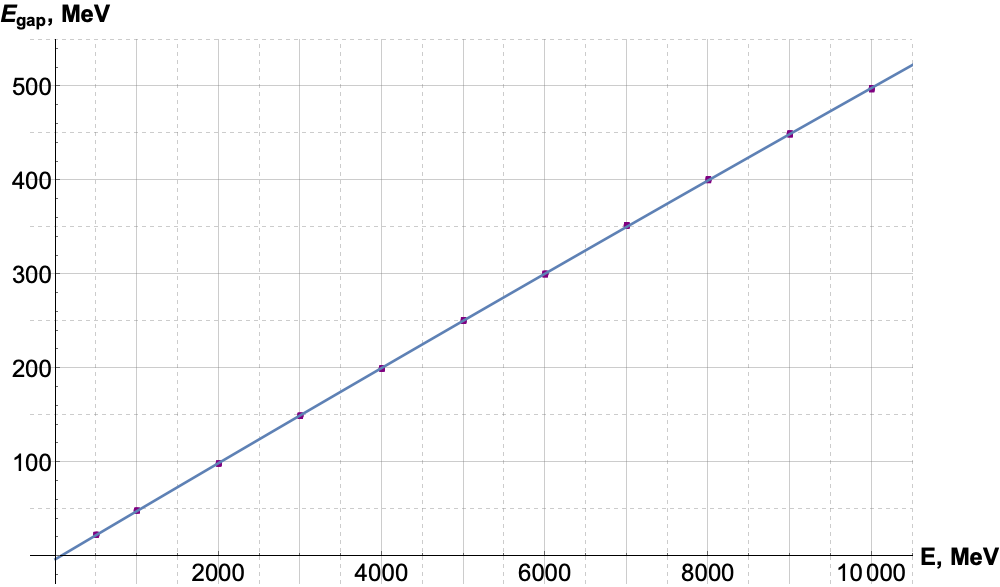

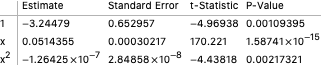

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [24]:
display(Image(filename = 'images/png/calib2.png', retina = False, width = 550))
display(Image(filename = 'images/png/fit_res2.png', retina = False, width = 550))
res2 = pd.read_csv('fit_res2.csv', header=None)
c2, b2, a2, chi2 = res2.iloc[0][0], res2.iloc[0][1], res2.iloc[0][2], res2.iloc[2][0]
print_math(r'Fit \; function: \quad E_{gap} = aE_{real}^2 + bE_{real} + c,')
print_math(f'Where \quad a = {round(a2, 10)}, \quad  b = {round(b2, 5)} \quad  c = {round(c2, 5)}')
print_math(r'\dfrac{\chi^2}{\nu}  = ' + f'{round(chi2, 3)}')

So now we can recover real energy of particles colliding in our detector with only $ E_{gap} $ obtained from our detector gap and $ a, b, c $ coefficients known, using calibration function
$$ E_{real} = \dfrac{-b + \sqrt{b^2 - 4 a(c - E_{gap})}}{2a} $$

In [10]:
def get_calibrated(Egap):
    D = b2 ** 2 - 4 * a2 * (c2 - Egap)
    E_real = (-b2 + np.sqrt(D)) / (2 * a2)
    return(E_real)

## Recovering part

Here we generate 11 random energies, then simulate collisions in Geant4 with them

In [11]:
# import random

# new_energy = []
# new_energy.append(round(random.uniform(100, 500)))
# for i in range(0, 10):
#     new_energy.append(round(random.uniform(0 + 1000 * i, 1000 * (i + 1))))
# new_energy

In [12]:
new_energy = [874, 1357, 1942, 2936, 3532, 4134, 5007, 6305, 7175, 8017, 9763]

#### We import $ E_{gap} $ datasets from genereted ROOT files with with "unknown" energies and then create $ E_{real} $ datasets corresponding to them with iterating through every point of a dateset and obtaining its real energy with calibration function 

As before, we also define approximate mean and sigma for have them as starting points of fit

In [13]:
varset_r = ROOT.RooArgSet(Egap, Ereal)

ds_red_list = []
mean0_red_list = []
sigma0_red_list = []

for i in range(0, 11):
    ch = ROOT.TChain('B4')
    filename = f'{i}re'
    file = glob.glob(path_to_data + filename + '.root')
    ch.Add(file[0])
    nEvt = ch.GetEntries()

    ds_red = ROOT.RooDataSet(f'data{i}', 'Dataset', varset_r)
    flag_empty = 1

    for evt in range(nEvt):
        if ch.GetEntry(evt) <= 0:
            break

        if (flag_empty != 1): # if new & !0, Write
            ds_red.add(varset_r)
            flag_empty = 1  # now empty and reset par

        Ereal.setVal(get_calibrated(ch.Egap))
        Egap.setVal(ch.Egap)
        flag_empty = 0

    if flag_empty != 1:
        ds_red.add(varset_r)  # write last event if needed 
    
    ds_red_list.append(ds_red)
    mean0_red_list.append(ds_red.mean(Ereal))
    sigma0_red_list.append(ds_red.sigma(Ereal))
    print(f'{i}-ds: mean0 = {round(mean0_red_list[i], 2)}, sigma0 = {round(sigma0_red_list[i],2)}')

0-ds: mean0 = 915.57, sigma0 = 192.14
1-ds: mean0 = 1398.47, sigma0 = 236.79
2-ds: mean0 = 1972.64, sigma0 = 288.22
3-ds: mean0 = 2951.98, sigma0 = 336.08
4-ds: mean0 = 3558.74, sigma0 = 384.38
5-ds: mean0 = 4137.23, sigma0 = 418.67
6-ds: mean0 = 5004.19, sigma0 = 459.99
7-ds: mean0 = 6316.86, sigma0 = 515.24
8-ds: mean0 = 7165.78, sigma0 = 560.53
9-ds: mean0 = 8050.76, sigma0 = 607.85
10-ds: mean0 = 9782.81, sigma0 = 681.98


#### We fit our $ E_{real} $ datasets

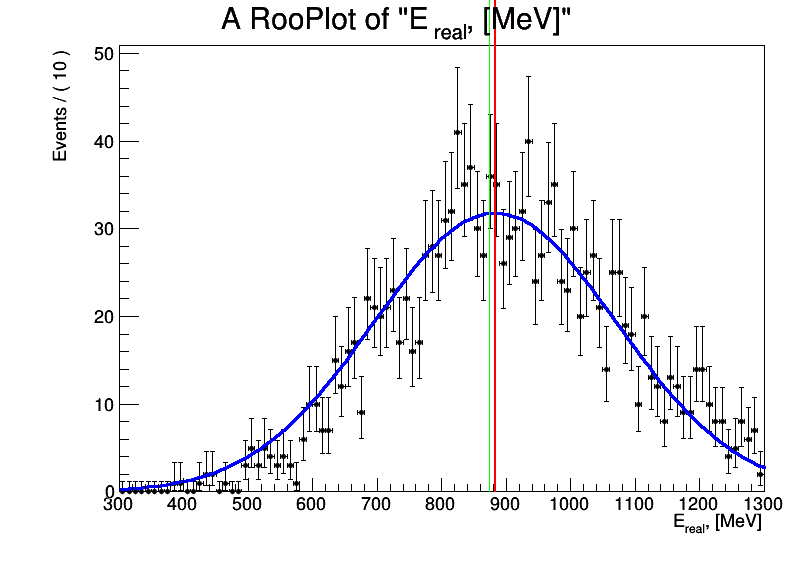

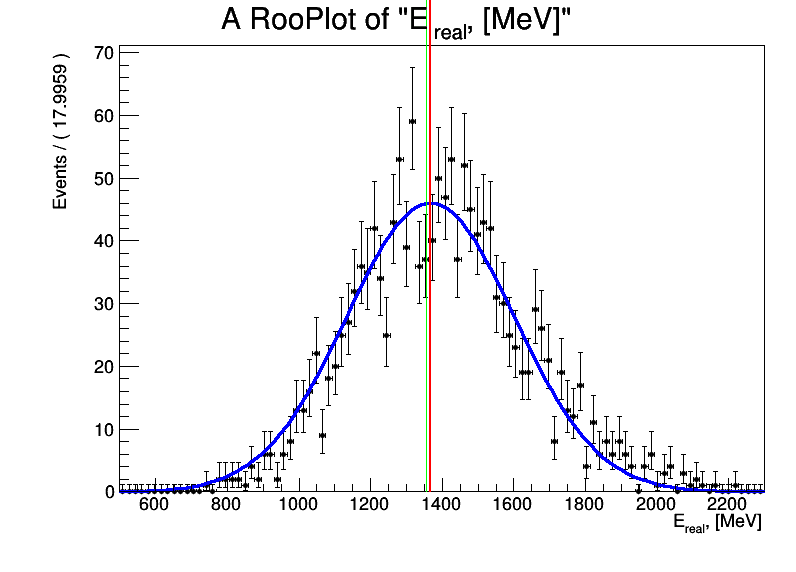

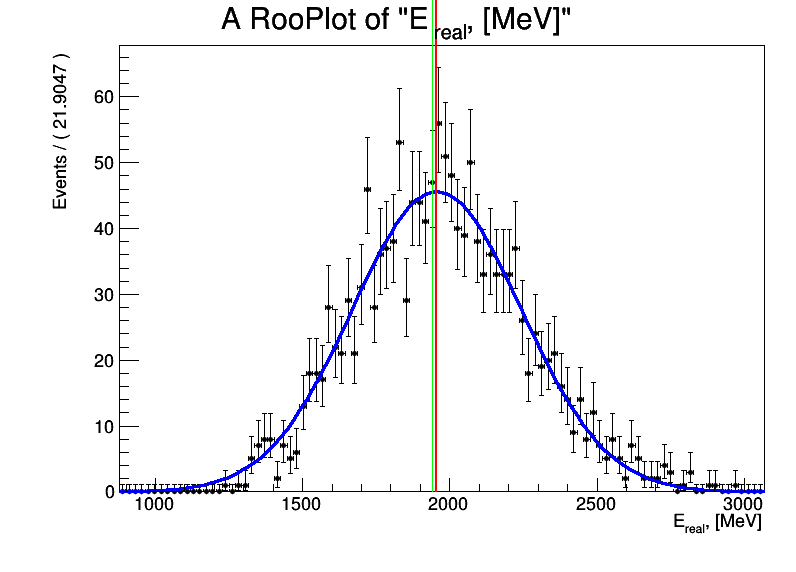

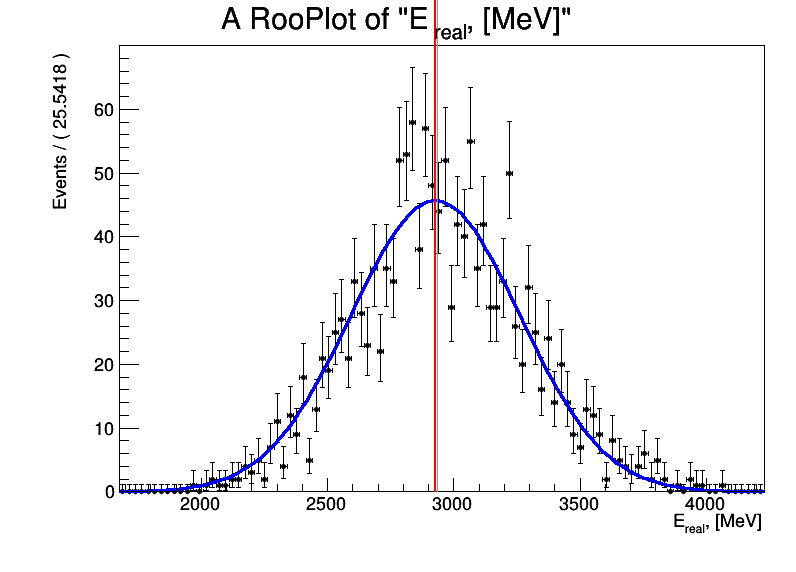

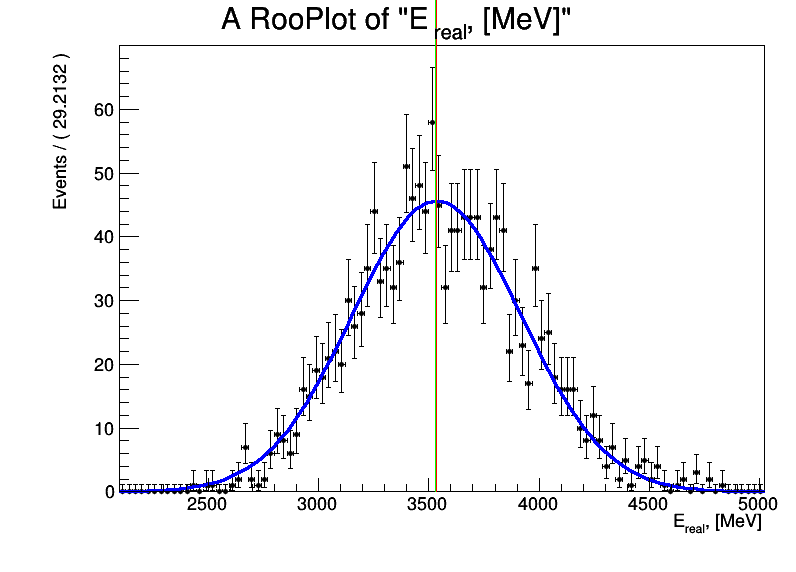

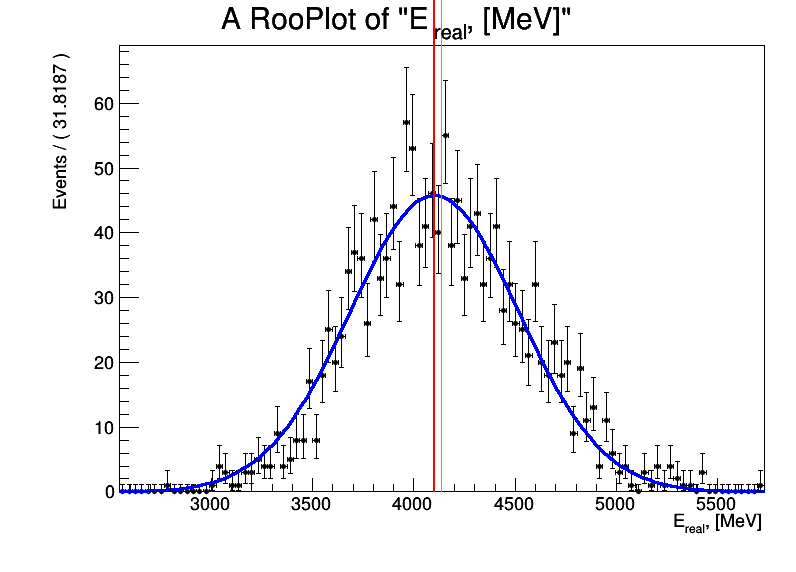

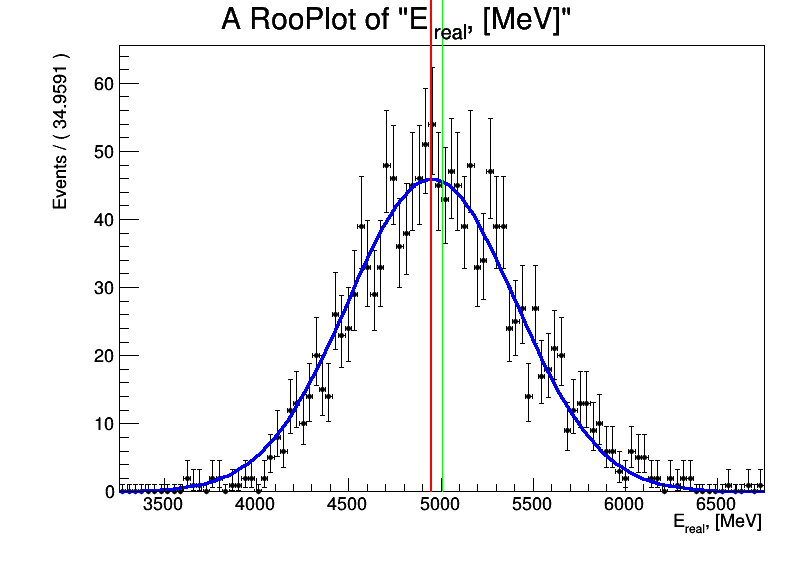

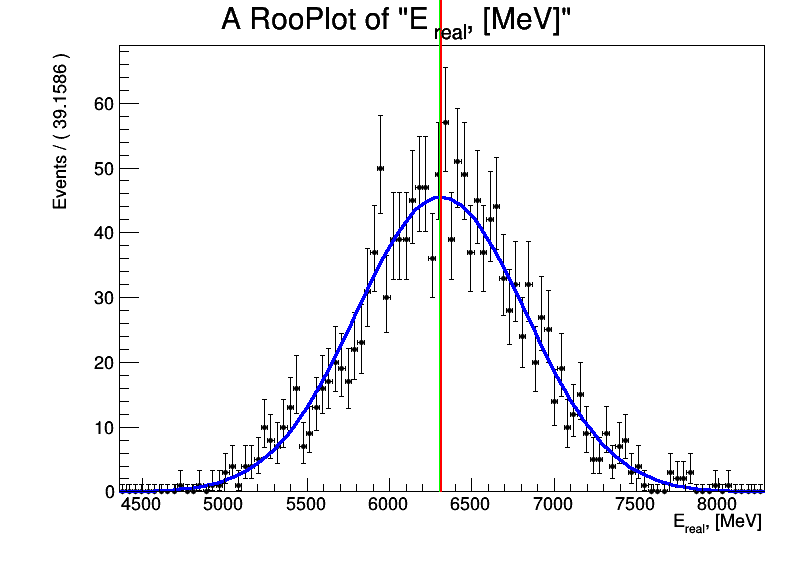

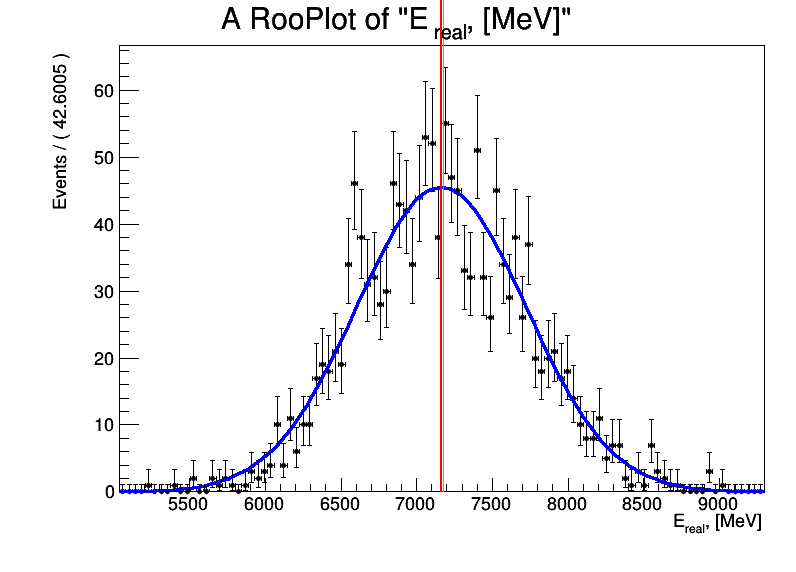

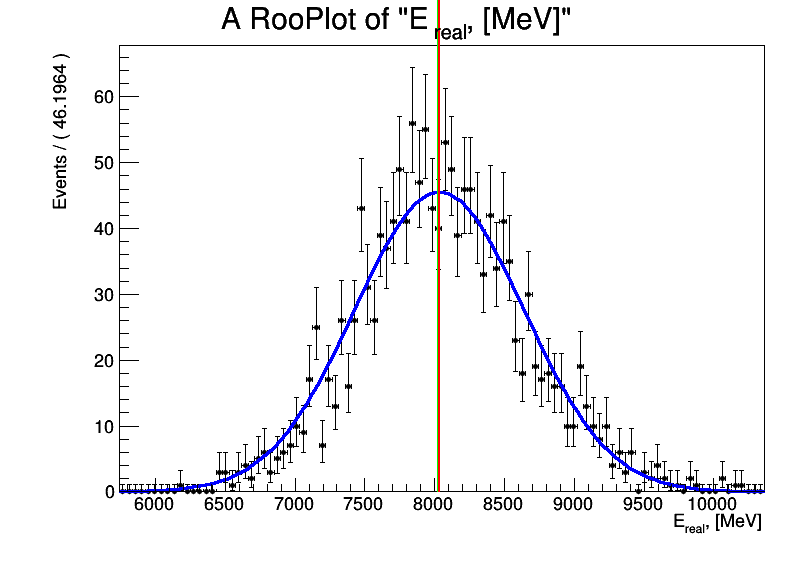

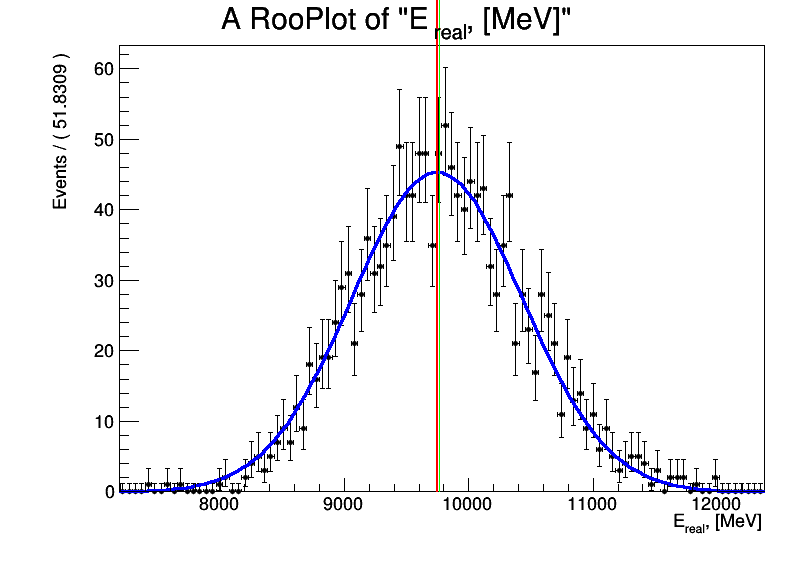

0-ds: mean = 882.84 +- 7.6, sigma = 188.2465 +- 3.48 
1-ds: mean = 1367.03 +- 9.55, sigma = 233.9482 +- 4.31 
2-ds: mean = 1956.12 +- 10.65, sigma = 287.4752 +- 5.25 
3-ds: mean = 2927.16 +- 13.62, sigma = 334.821 +- 6.13 
4-ds: mean = 3535.84 +- 15.3, sigma = 383.4398 +- 7.01 
5-ds: mean = 4101.11 +- 17.05, sigma = 416.5605 +- 7.63 
6-ds: mean = 4951.12 +- 17.96, sigma = 455.5618 +- 8.36 
7-ds: mean = 6312.99 +- 20.87, sigma = 515.2263 +- 9.41 
8-ds: mean = 7163.25 +- 21.49, sigma = 560.5238 +- 10.23 
9-ds: mean = 8033.74 +- 22.58, sigma = 607.4669 +- 11.09 
10-ds: mean = 9745.9 +- 27.72, sigma = 684.8099 +- 12.91 
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 7 remote server process.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: deactivating const optimization

  RooFitResult: minimized FCN value: 10000.3, estimated distance to minimum: 3.26605e-06
                covariance matrix 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cB
Info in <TCanvas::Print>: png file images/png/recovered0.png has been created
Info in <TCanvas::Print>: pdf file images/pdf/recovered0.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cB
Info in <TCanvas::Print>: png file images/png/recovered1.png has been created
Info in <TCanvas::Print>: pdf file images/pdf/recovered1.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cB
Info in <TCanvas::Print>: png file images/png/recovered2.png has been created
Info in <TCanvas::Print>: pdf file images/pdf/recovered2.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cB
Info in <TCanvas::Print>: png file images/png/recovered3.png has been created
Info in <TCanvas::Print>: pdf file images/pdf/recovered3.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cB
Info in <TCanvas::Print>: 

In [15]:
mean_red_list = []
mean_er_red_list = []
gaus_red_list = []
sigma_g_red_list = []
sigma_ge_red_list = []

for i in range(0, 11):  
    m = mean0_red_list[i]
    s = sigma0_red_list[i]

    mean_ered  = ROOT.RooRealVar ('mean_ered' , 'mean ', m - 50, 0.1 * m , 2 * m)
    sigma_ered = ROOT.RooRealVar ('sigma_ered', 'sigma', s, 0.2 * s , 10 * s)
    mean_eredl = ROOT.RooRealVar ('mean_eredl' , 'meanl ', m, m - s , m + s)
    sigma_eredl= ROOT.RooRealVar ('sigma_eredl', 'sigmal', s * 0.3, 0, 10 * s)
    tail       = ROOT.RooRealVar ('tail'      , 'tail' , 0.00001, -1       , 1)

    pdf_ered   = ROOT.RooGaussian('pdf_ered'  , 'gaus' , Ereal, mean_ered, sigma_ered)
    pdf_nov    = ROOT.RooNovosibirsk('pdf_nov', 'nov'  , Ereal, mean_ered, sigma_ered, tail)
    pdf_landau = ROOT.RooLandau  ('pdfEcalib_l' , 'landau', Ereal, mean_eredl, sigma_eredl)
    
    frac = ROOT.RooRealVar(
    'sig1frac', 'fraction of component 1', 0.5, 0., 1.)
    pdfSum      = ROOT.RooAddPdf(
    'pdfSum', 'pdfSum', ROOT.RooArgList(pdf_ered, pdf_landau), ROOT.RooArgList(frac))
    pdflxg = ROOT.RooFFTConvPdf ('pdflxg','landau (X) gauss', Ereal, pdf_landau, pdf_ered)

    if i < 3:
#         Ereal.setBins(1000, 'cache')
        fit_rr = pdf_nov.fitTo(ds_red_list[i], ROOT.RooFit.NumCPU(7), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Save())
        fit_rr.Print()
    else:
        fit_rr = pdf_nov.fitTo(ds_red_list[i], ROOT.RooFit.NumCPU(7), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Save())
        fit_rr.Print()
    
    gaus_red_list.append(pdf_ered)
    mean_red_list.append(mean_ered.getVal())
    mean_er_red_list.append(mean_ered.getError())
    sigma_g_red_list.append(sigma_ered.getVal())
    sigma_ge_red_list.append(sigma_ered.getError())
    
    if i == 0:
        fr_min = 300 
        fr_max = 1300
    else:
        fr_min = m - 3.8 * s
        fr_max = m + 3.8 * s
    
    bufram = Ereal.frame(fr_min, fr_max, 100)

    _MYW = 800
    _MYH = 600
    _MYT = 0.08*_MYH
    _MYB = 0.14*_MYH
    _MYL = 0.15*_MYW
    _MYR = 0.04*_MYW

    cB = ROOT.TCanvas('cB','cB',_MYW,_MYH)
    cB.SetLeftMargin( _MYL/_MYW )
    cB.SetRightMargin( _MYR/_MYW )
    cB.SetTopMargin( _MYT/_MYH )
    cB.SetBottomMargin( _MYB/_MYH )
    cB.SetTickx(0)
    cB.SetTicky(0)
    bufram.GetYaxis().SetTitleOffset(1.3)


    ds_red_list[i].plotOn(bufram, ROOT.RooFit.MarkerSize(0.6), ROOT.RooFit.Name('data'))
    gaus_red_list[i].plotOn(bufram)
    pdf_ered.plotOn(bufram)
    bufram.Draw()
    
    if i == 0:
        l = ROOT.TLine(mean_red_list[i], 0, mean_red_list[i], 70)
    else:
        l = ROOT.TLine(mean_red_list[i], 0, mean_red_list[i], 90)
    l.SetLineWidth(2)
    l.SetLineColor(ROOT.kRed)
    l.Draw()
    
    if i == 0:
        lr = ROOT.TLine(new_energy[i], 0, new_energy[i], 70)
    else:
        lr = ROOT.TLine(new_energy[i], 0, new_energy[i], 90)
    lr.SetLineWidth(1)
    lr.SetLineColor(ROOT.kGreen)
    lr.Draw()

    cB.SaveAs(f'images/png/recovered{i}.png')
    cB.SaveAs(f'images/pdf/recovered{i}.pdf')
    display(Image(filename = f'images/png/recovered{i}.png', retina = False, width = 550))

for i in range(0, 11):
    print(f'{i}-ds: mean = {round(mean_red_list[i], 2)} +- {round(mean_er_red_list[i], 2)}, sigma = {round(sigma_g_red_list[i], 4)} +- {round(sigma_ge_red_list[i], 2)} ')

#### We create list of $ \dfrac{\Delta E_{real}}{E_{real}} $ for 10 obtained $ E_{real} $ points

In [17]:
deltaEtoE = []
deltaEtoE_err = []

for i in range(0, 11):
    dEtoE = sigma_g_red_list[i] / mean_red_list[i]
    err = dEtoE * np.sqrt( ((mean_er_red_list[i] / mean_red_list[i]) ** 2) + ((sigma_ge_red_list[i] / sigma_g_red_list[i]) ** 2) )
    deltaEtoE.append(dEtoE)
    deltaEtoE_err.append(err)

#### Export it to SCV with energy itself points

In [18]:
columns_red_list = ['Energy, MeV', 'Sigma(E), MeV', 'dE/E', 'Sigma(dE/E)']
df_red = pd.DataFrame(columns = columns_red_list)

for i in range(0, 11):
    a_log_red = [mean_red_list[i], mean_er_red_list[i], deltaEtoE[i], deltaEtoE_err[i]]
    df_red.loc[i] = a_log_red
    
df_red.to_csv('log_red.csv', index = False)
df_red

,"Energy, MeV","Sigma(E), MeV",dE/E,Sigma(dE/E)
0,882.841819,7.595959,0.213228,0.004350
1,1367.025162,9.549724,0.171137,0.003370
2,1956.119415,10.646983,0.146962,0.002802
3,2927.161411,13.624800,0.114384,0.002160
4,3535.835321,15.295629,0.108444,0.002038
5,4101.108026,17.046065,0.101573,0.001908
6,4951.119876,17.956039,0.092012,0.001721
7,6312.988982,20.870973,0.081614,0.001514
8,7163.252823,21.490750,0.078250,0.001448
9,8033.741433,22.580883,0.075614,0.001397


#### Then we fit exported SCV with in Wolfram Matematica and show fit output below

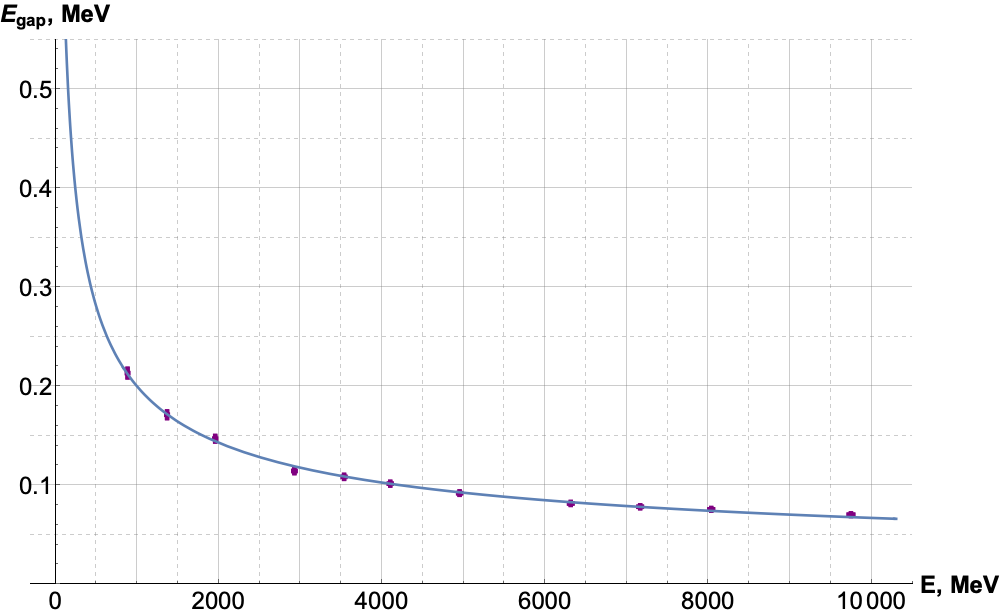

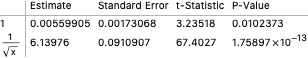

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [28]:
display(Image(filename = 'images/png/re.png', retina = False, width = 550))
display(Image(filename = 'images/png/fit_re_res.png', retina = False, width = 550))
res_r = pd.read_csv('fit_re_res.csv', header=None)
a_r, b_r, chi_r = res_r.iloc[0][0], res_r.iloc[0][1], res_r.iloc[2][0]
print_math(r'Fit \; function: \quad \frac{\Delta E}{E} = a + \frac{b}{\sqrt{E}},')
print_math(f'Where \quad a = {round(a_r, 5)}, \quad  b = {round(b_r, 5)}')
print_math(r'\dfrac{\chi^2}{\nu}  = ' + f'{round(chi_r, 3)}')

In [16]:
residentials_e = []

for i in range(0, 11):
    res = round(new_energy[i] - mean_red_list[i])
    residentials_e.append(res)
    print(f'{i}-run: realE = {new_energy[i]}, rec E = {round(mean_red_list[i])} +- {round(mean_er_red_list[i])}, recSigma = {round(sigma_g_red_list[i])} +- {round(sigma_g_red_list[i])},  delta = {residentials_e[i]}')

0-run: realE = 874, rec E = 883 +- 8, recSigma = 188 +- 188,  delta = -9
1-run: realE = 1357, rec E = 1367 +- 10, recSigma = 234 +- 234,  delta = -10
2-run: realE = 1942, rec E = 1956 +- 11, recSigma = 287 +- 287,  delta = -14
3-run: realE = 2936, rec E = 2927 +- 14, recSigma = 335 +- 335,  delta = 9
4-run: realE = 3532, rec E = 3536 +- 15, recSigma = 383 +- 383,  delta = -4
5-run: realE = 4134, rec E = 4101 +- 17, recSigma = 417 +- 417,  delta = 33
6-run: realE = 5007, rec E = 4951 +- 18, recSigma = 456 +- 456,  delta = 56
7-run: realE = 6305, rec E = 6313 +- 21, recSigma = 515 +- 515,  delta = -8
8-run: realE = 7175, rec E = 7163 +- 21, recSigma = 561 +- 561,  delta = 12
9-run: realE = 8017, rec E = 8034 +- 23, recSigma = 607 +- 607,  delta = -17
10-run: realE = 9763, rec E = 9746 +- 28, recSigma = 685 +- 685,  delta = 17
